# Hackathon

In [ ]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import differential_evolution
from scipy.interpolate import CubicSpline
from datetime import datetime, timedelta


In [141]:
file_path = 'data_ncov2019.csv'

# Read headers
df = pd.read_csv(file_path)
headers = df.columns.tolist()
print("Headers in the CSV file:")

for header in df:
    print(f"- {header}")


Headers in the CSV file:
- EVENT_NAME
- SOURCE
- DATE_LOW
- DATE_HIGH
- DATE_REPORT
- DATE_TYPE
- SPATIAL_RESOLUTION
- AL0_CODE
- AL0_NAME
- AL1_CODE
- AL1_NAME
- AL2_NAME
- AL3_NAME
- LOCALITY_NAME
- LOCATION_TYPE
- CONFIRM_STATUS
- OUTCOME
- CUMULATIVE_FLAG
- VALUE


In [142]:
# Print the first few rows of the DataFrame
print("First few rows of the CSV file:")
print(df.head())

First few rows of the CSV file:
  EVENT_NAME              SOURCE    DATE_LOW   DATE_HIGH DATE_REPORT  \
0  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
1  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
2  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
3  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
4  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   

       DATE_TYPE SPATIAL_RESOLUTION AL0_CODE AL0_NAME AL1_CODE AL1_NAME  \
0  Symptom onset                AL0       CN    China      NaN      NaN   
1  Symptom onset                AL0       CN    China      NaN      NaN   
2  Symptom onset                AL0       CN    China      NaN      NaN   
3  Symptom onset                AL0       CN    China      NaN      NaN   
4  Symptom onset                AL0       CN    China      NaN      NaN   

  AL2_NAME AL3_NAME LOCALITY_NAME LOCATION_TYPE CONFIRM_STATUS OUTCOME  \
0      NaN

## Trying SIRD model

In [143]:
# Example: Filter confirmed cumulative cases at country-level
filtered_df = df[
    (df['OUTCOME'] == 'CASE') &
    (df['CONFIRM_STATUS'] == 'CONFIRMED') &
    (df['SPATIAL_RESOLUTION'] == 'AL0') &
    (df['CUMULATIVE_FLAG'] == True)
]

print(filtered_df.head())


    EVENT_NAME              SOURCE    DATE_LOW   DATE_HIGH DATE_REPORT  \
61   nCoV_2019  Multisource Fusion  2020-01-01  2020-01-03  2020-01-11   
97   nCoV_2019  Multisource Fusion  2020-01-03  2020-01-03  2020-01-16   
117  nCoV_2019  Multisource Fusion  2020-01-05  2020-01-08  2020-01-17   
129  nCoV_2019  Multisource Fusion  2020-01-05  2020-01-05  2020-01-17   
163  nCoV_2019  Multisource Fusion  2020-01-09  2020-01-09  2020-01-23   

                  DATE_TYPE SPATIAL_RESOLUTION AL0_CODE  AL0_NAME AL1_CODE  \
61   Authority notification                AL0       CN     China      NaN   
97            Symptom onset                AL0       JP     Japan      NaN   
117           Symptom onset                AL0       CN     China      NaN   
129           Symptom onset                AL0       TH  Thailand      NaN   
163                  Report                AL0       CN     China      NaN   

    AL1_NAME AL2_NAME AL3_NAME LOCALITY_NAME         LOCATION_TYPE  \
61       NaN    

In [144]:
# Filter for China (AL0_CODE = 'CN') with CONFIRMED/PROBABLE cases and deaths
china_sird_data = df[
    (df['AL0_CODE'] == 'CN') &
    (df['CONFIRM_STATUS'].isin(['CONFIRMED', 'PROBABLE'])) &  # Use CONFIRMED+PROBABLE for active cases
    (df['OUTCOME'].isin(['CASE', 'DEATH'])) &                # Separate cases and deaths
    (df['CUMULATIVE_FLAG'] == True)                          # Use cumulative counts
][['DATE_REPORT', 'CONFIRM_STATUS', 'OUTCOME', 'VALUE']]    # Keep essential columns

print(china_sird_data.head())

   DATE_REPORT CONFIRM_STATUS OUTCOME  VALUE
61  2020-01-11      CONFIRMED    CASE     41
63  2020-01-11      CONFIRMED   DEATH      1
73  2020-01-11      CONFIRMED    CASE     41
75  2020-01-11      CONFIRMED   DEATH      1
85  2020-01-11      CONFIRMED    CASE     41


In [145]:
# Pivot to get cases/deaths as columns
china_pivoted = china_sird_data.pivot_table(
    index='DATE_REPORT', 
    columns='OUTCOME', 
    values='VALUE', 
    aggfunc='sum'
).reset_index()

# Forward-fill missing dates (ensure continuity)
china_pivoted['DATE_REPORT'] = pd.to_datetime(china_pivoted['DATE_REPORT'])
china_pivoted = china_pivoted.set_index('DATE_REPORT').asfreq('D').ffill().reset_index()

# Add date filtering:
start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2022-12-31')
mask = (china_pivoted['DATE_REPORT'] >= start_date) & (china_pivoted['DATE_REPORT'] <= end_date)
china_pivoted = china_pivoted.loc[mask]

# Total cumulative cases and deaths
cumulative_cases = china_pivoted['CASE'].values
cumulative_deaths = china_pivoted['DEATH'].values

# Estimate recovered (assuming 14-day recovery period)
recovery_lag = 14
recovered = np.zeros_like(cumulative_cases)
recovered[recovery_lag:] = cumulative_cases[:-recovery_lag] - cumulative_deaths[:-recovery_lag]

# Active infections = Cumulative cases - Recovered - Deaths
active_infections = cumulative_cases - recovered - cumulative_deaths

In [146]:
# Combine into a clean DataFrame
sird_data = pd.DataFrame({
    'Date': china_pivoted['DATE_REPORT'],
    'Susceptible': N - active_infections - recovered - cumulative_deaths,  # N = population of China
    'Infected': active_infections,
    'Recovered': recovered,
    'Deceased': cumulative_deaths
})

print(sird_data.head())

          Date   Susceptible  Infected  Recovered  Deceased
356 2021-01-01  1.399776e+09  211338.0        0.0   13137.0
357 2021-01-02  1.399775e+09  211382.0        0.0   13137.0
358 2021-01-03  1.399775e+09  211430.0        0.0   13137.0
359 2021-01-04  1.399775e+09  211496.0        0.0   13137.0
360 2021-01-05  1.399775e+09  211529.0        0.0   13137.0


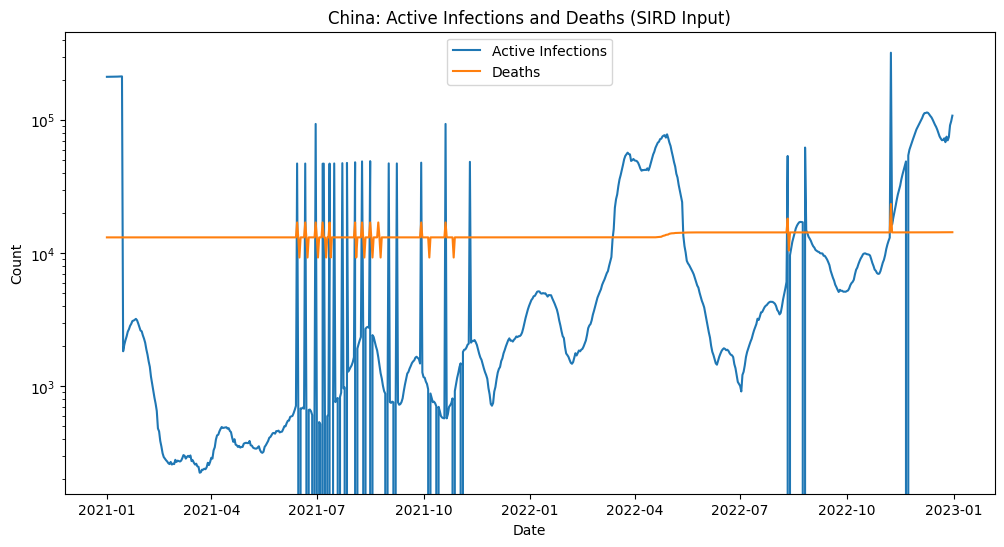

In [147]:
plt.figure(figsize=(12, 6))
plt.plot(sird_data['Date'], sird_data['Infected'], label='Active Infections')
plt.plot(sird_data['Date'], sird_data['Deceased'], label='Deaths')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.title('China: Active Infections and Deaths (SIRD Input)')
plt.yscale('log')
plt.show()

Implement model

Optimized Parameters: beta=0.005329090207616301, gamma=0.009687977249507417, mu=1.4201380856879181e-05


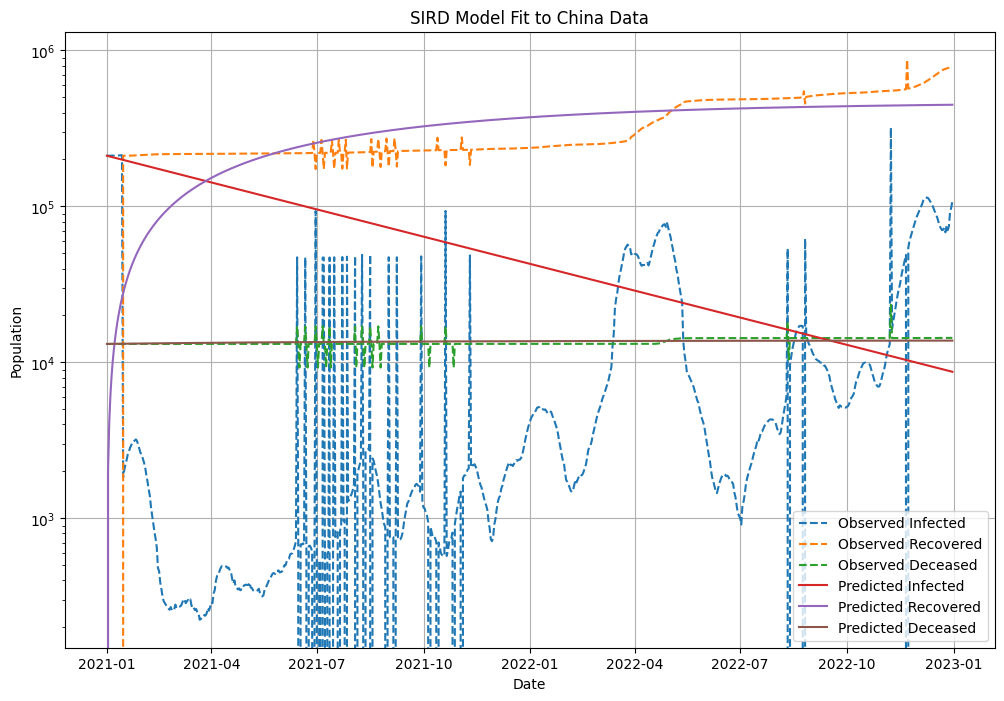

In [148]:
# Define the SIRD model
def sird_model(y, t, beta, gamma, mu, N):
    S, I, R, D = y
    dS_dt = -beta * S * I / N  # Rate of susceptible individuals becoming infected
    dI_dt = beta * S * I / N - gamma * I - mu * I  # Infected individuals recovering or dying
    dR_dt = gamma * I  # Recovered individuals
    dD_dt = mu * I  # Deceased individuals
    return [dS_dt, dI_dt, dR_dt, dD_dt]


# Approximate population of China 
N = 1.4e9  

# Initial conditions
S0 = N - active_infections[0] - recovered[0] - cumulative_deaths[0]  # Susceptible
I0 = active_infections[0]  # Infected
R0 = recovered[0]  # Recovered
D0 = cumulative_deaths[0]  # Deceased

# Assign observed values
observed_I = active_infections  
observed_R = recovered          
observed_D = cumulative_deaths 

y0 = [S0, I0, R0, D0]  # Initial state vector

# time
t = np.arange(len(sird_data))

# Use minimize instead of curve_fit for this type of optimization
def objective_function(params):
    beta, gamma, mu = params
    solution = odeint(sird_model, y0, t, args=(beta, gamma, mu, N))
    S_pred, I_pred, R_pred, D_pred = solution.T
    
    # Calculate error between model predictions and observations
    error = (
        np.sum((I_pred - observed_I) ** 2) +  
        np.sum((R_pred - observed_R) ** 2) +  
        np.sum((D_pred - observed_D) ** 2)    
    )
    return error

# Initial guesses for parameters
initial_params = [0.5, 1/14, 0.01]  # beta, gamma, mu

# Optimize parameters using minimize
result = minimize(
    objective_function,
    initial_params,
    method='L-BFGS-B',
    bounds=[(0, 1), (0, 1), (0, 1)]  
)

# Optimized parameters
beta_opt, gamma_opt, mu_opt = result.x
print(f"Optimized Parameters: beta={beta_opt}, gamma={gamma_opt}, mu={mu_opt}")

# Simulate the model
solution = odeint(sird_model, y0, t, args=(beta_opt, gamma_opt, mu_opt, N))
S_pred, I_pred, R_pred, D_pred = solution.T


# Plot observed vs. predicted values
plt.figure(figsize=(12, 8))

plt.plot(sird_data['Date'], active_infections, label="Observed Infected", linestyle="--")
plt.plot(sird_data['Date'], recovered, label="Observed Recovered", linestyle="--")
plt.plot(sird_data['Date'], cumulative_deaths, label="Observed Deceased", linestyle="--")

plt.plot(sird_data['Date'], I_pred, label="Predicted Infected")
plt.plot(sird_data['Date'], R_pred, label="Predicted Recovered")
plt.plot(sird_data['Date'], D_pred, label="Predicted Deceased")

plt.xlabel("Date")
plt.ylabel("Population")
plt.title("SIRD Model Fit to China Data")
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

The flat I(t) prediction suggests that β (transmission rate) is assumed constant, but real-world interventions (lockdowns, vaccinations) cause 
β to change over time. We try to modify the model to allow β(t) as a piecewise function or spline.

differential_evolution step 1: f(x)= 16474321600.553337
differential_evolution step 2: f(x)= 15789960011.017433
differential_evolution step 3: f(x)= 15789960011.017433
differential_evolution step 4: f(x)= 12627071969.9509
differential_evolution step 5: f(x)= 12627071969.9509
differential_evolution step 6: f(x)= 12627071969.9509
differential_evolution step 7: f(x)= 12627071969.9509
differential_evolution step 8: f(x)= 12627071969.9509
differential_evolution step 9: f(x)= 12627071969.9509
differential_evolution step 10: f(x)= 12574435039.66061
differential_evolution step 11: f(x)= 11358437943.378355
differential_evolution step 12: f(x)= 11358437943.378355
differential_evolution step 13: f(x)= 11358437943.378355
differential_evolution step 14: f(x)= 11358437943.378355
differential_evolution step 15: f(x)= 9836783449.158241
differential_evolution step 16: f(x)= 9828691862.693535
differential_evolution step 17: f(x)= 9828691862.693535
differential_evolution step 18: f(x)= 9828691862.693535


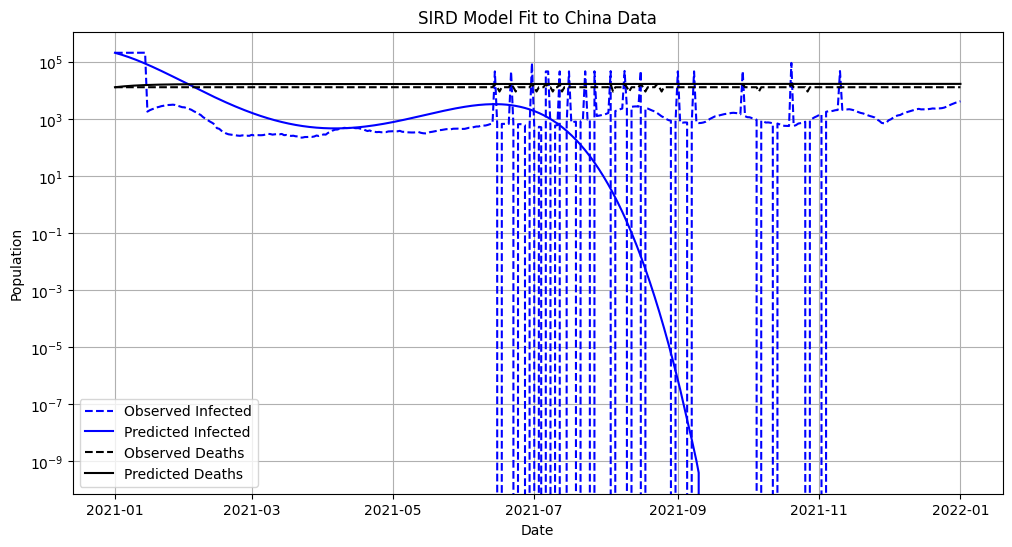

In [157]:
# Filter China data with CONFIRMED/PROBABLE cases and deaths
china_data = df[
    (df['AL0_CODE'] == 'CN') &
    (df['CONFIRM_STATUS'].isin(['CONFIRMED', 'PROBABLE'])) &
    (df['OUTCOME'].isin(['CASE', 'DEATH'])) &
    (df['CUMULATIVE_FLAG'] == True)
][['DATE_REPORT', 'OUTCOME', 'VALUE']]

# Pivot and clean data
china_pivot = china_data.pivot_table(
    index='DATE_REPORT', 
    columns='OUTCOME', 
    values='VALUE', 
    aggfunc='sum'
).reset_index().sort_values('DATE_REPORT')

# Forward-fill missing dates
china_pivot['DATE_REPORT'] = pd.to_datetime(china_pivot['DATE_REPORT'])
china_pivot = china_pivot.set_index('DATE_REPORT').asfreq('D').ffill().reset_index()

start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2022-01-01')
mask = (china_pivot['DATE_REPORT'] >= start_date) & (china_pivot['DATE_REPORT'] <= end_date)
china_pivot = china_pivot.loc[mask]

# Calculate active infections (I) and recovered (R)
cumulative_cases = china_pivot['CASE'].values
cumulative_deaths = china_pivot['DEATH'].values
recovery_lag = 14

recovered = np.zeros_like(cumulative_cases)
recovered[recovery_lag:] = cumulative_cases[:-recovery_lag] - cumulative_deaths[:-recovery_lag]
active_infections = cumulative_cases - recovered - cumulative_deaths

# Create sird_data DataFrame
sird_data = pd.DataFrame({
    'Date': china_pivot['DATE_REPORT'],
    'Susceptible': 1.4e9 - active_infections - recovered - cumulative_deaths,
    'Infected': active_infections,
    'Recovered': recovered,
    'Deceased': cumulative_deaths
})

# Define observed data and time vector
observed_I = sird_data['Infected'].values
observed_R = sird_data['Recovered'].values
observed_D = sird_data['Deceased'].values
t = np.arange(len(sird_data))  # Corrected to match data length
N = 1.4e9

# Time-Varying SIRD Model
def sird_model(t, y, beta_spline, gamma, mu, N):
    S, I, R, D = y
    beta = beta_spline(t)
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - mu * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dIdt, dRdt, dDdt]

# Optimization Setup
knot_dates = np.array([0, 60, 120, 180])
beta_knots = [0.6, 0.3, 0.4, 0.2]

def objective_function(params):
    gamma, mu, *beta_vals = params
    beta_spline = CubicSpline(knot_dates, beta_vals, extrapolate="bounds")
    solution = odeint(sird_model, y0, t, args=(beta_spline, gamma, mu, N), tfirst=True)
    S_pred, I_pred, R_pred, D_pred = solution.T
    error = (
        10 * np.mean((I_pred - observed_I)**2) + 
        np.mean((R_pred - observed_R)**2) + 
        np.mean((D_pred - observed_D)**2)
    )
    return error

# Initial conditions
I0 = observed_I[0]
R0 = observed_R[0]
D0 = observed_D[0]
S0 = N - I0 - R0 - D0
y0 = [S0, I0, R0, D0]

# Bounds and optimization
bounds = [(0.01, 0.5), (0.001, 0.1)] + [(0.01, 1.0)] * 4
result = differential_evolution(objective_function, bounds, strategy='best1bin', maxiter=100, popsize=15, tol=0.001, disp=True)

# Extract parameters and simulate
gamma_opt, mu_opt, *beta_knots_opt = result.x
beta_spline_opt = CubicSpline(knot_dates, beta_knots_opt)
solution = odeint(sird_model, y0, t, args=(beta_spline_opt, gamma_opt, mu_opt, N), tfirst=True)
S_pred, I_pred, R_pred, D_pred = solution.T

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(sird_data['Date'], observed_I, 'b--', label='Observed Infected')
plt.plot(sird_data['Date'], I_pred, 'b-', label='Predicted Infected')
plt.plot(sird_data['Date'], observed_D, 'k--', label='Observed Deaths')
plt.plot(sird_data['Date'], D_pred, 'k-', label='Predicted Deaths')
plt.xlabel("Date")
plt.ylabel("Population")
plt.title("SIRD Model Fit to China Data")
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

# Lebanon

In [132]:
# Filter for lebanon (AL0_CODE = 'LB') with CONFIRMED/PROBABLE cases and deaths
lebanon_sird_data = df[
    (df['AL0_CODE'] == 'LB') &
    (df['CONFIRM_STATUS'].isin(['CONFIRMED', 'PROBABLE'])) &  # Use CONFIRMED+PROBABLE for active cases
    (df['OUTCOME'].isin(['CASE', 'DEATH'])) &                # Separate cases and deaths
    (df['CUMULATIVE_FLAG'] == True)                          # Use cumulative counts
][['DATE_REPORT', 'CONFIRM_STATUS', 'OUTCOME', 'VALUE']]    # Keep essential columns

print(lebanon_sird_data.head())

      DATE_REPORT CONFIRM_STATUS OUTCOME  VALUE
20934  2020-02-22      CONFIRMED    CASE      1
21877  2020-02-27      CONFIRMED    CASE      2
28085  2020-02-28      CONFIRMED    CASE      3
29898  2020-03-01      CONFIRMED    CASE      7
34025  2020-03-03      CONFIRMED    CASE     10


      DATE_REPORT CONFIRM_STATUS OUTCOME  VALUE
20934  2020-02-22      CONFIRMED    CASE      1
21877  2020-02-27      CONFIRMED    CASE      2
28085  2020-02-28      CONFIRMED    CASE      3
29898  2020-03-01      CONFIRMED    CASE      7
34025  2020-03-03      CONFIRMED    CASE     10
Optimized Parameters: beta=0.03967509252983866, gamma=0.05254571889969224, mu=0.0008016911677828794


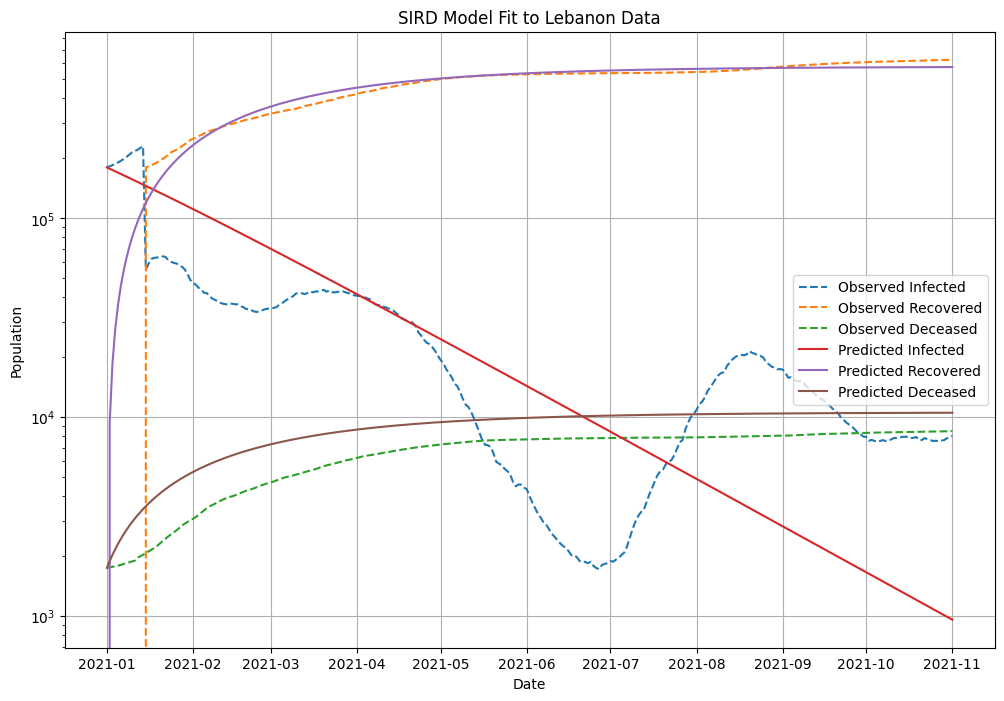

In [ ]:
# Pivot to get cases/deaths as columns
lebanon_pivoted = lebanon_sird_data.pivot_table(
    index='DATE_REPORT', 
    columns='OUTCOME', 
    values='VALUE', 
    aggfunc='sum'
).reset_index()

# Forward-fill missing dates (ensure continuity)
lebanon_pivoted['DATE_REPORT'] = pd.to_datetime(lebanon_pivoted['DATE_REPORT'])
lebanon_pivoted = lebanon_pivoted.set_index('DATE_REPORT').asfreq('D').ffill().reset_index()

# Add date filtering:
start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2021-11-01')
mask = (lebanon_pivoted['DATE_REPORT'] >= start_date) & (lebanon_pivoted['DATE_REPORT'] <= end_date)
lebanon_pivoted = lebanon_pivoted.loc[mask]

# Total cumulative cases and deaths
cumulative_cases = lebanon_pivoted['CASE'].values
cumulative_deaths = lebanon_pivoted['DEATH'].values

# Estimate recovered (assuming 14-day recovery period)
recovery_lag = 14
recovered = np.zeros_like(cumulative_cases)
recovered[recovery_lag:] = cumulative_cases[:-recovery_lag] - cumulative_deaths[:-recovery_lag]

# Active infections = Cumulative cases - Recovered - Deaths
active_infections = cumulative_cases - recovered - cumulative_deaths

N = 5.718e6  # Population of Lebanon in 2021

# Combine into a clean DataFrame
sird_data = pd.DataFrame({
    'Date': lebanon_pivoted['DATE_REPORT'],
    'Susceptible': N - active_infections - recovered - cumulative_deaths,  # N = population of China
    'Infected': active_infections,
    'Recovered': recovered,
    'Deceased': cumulative_deaths
})


# Define the SIRD model
def sird_model(y, t, beta, gamma, mu, N):
    S, I, R, D = y
    dS_dt = -beta * S * I / N  # Rate of susceptible individuals becoming infected
    dI_dt = beta * S * I / N - gamma * I - mu * I  # Infected individuals recovering or dying
    dR_dt = gamma * I  # Recovered individuals
    dD_dt = mu * I  # Deceased individuals
    return [dS_dt, dI_dt, dR_dt, dD_dt]


# Initial conditions
S0 = N - active_infections[0] - recovered[0] - cumulative_deaths[0]  # Susceptible
I0 = active_infections[0]  # Infected
R0 = recovered[0]  # Recovered
D0 = cumulative_deaths[0]  # Deceased

# Assign observed values
observed_I = active_infections  
observed_R = recovered          
observed_D = cumulative_deaths 

y0 = [S0, I0, R0, D0]  

# Time
t = np.arange(len(sird_data))


# Use minimize instead of curve_fit for this type of optimization
def objective_function(params):
    beta, gamma, mu = params
    solution = odeint(sird_model, y0, t, args=(beta, gamma, mu, N))
    S_pred, I_pred, R_pred, D_pred = solution.T
    
    # Calculate error between model predictions and observations
    error = (
        np.sum((I_pred - observed_I) ** 2) +  # Error in infected
        np.sum((R_pred - observed_R) ** 2) +  # Error in recovered
        np.sum((D_pred - observed_D) ** 2)    # Error in deceased
    )
    return error

# Initial guesses for parameters
initial_params = [0.5, 1/14, 0.01] 

# Optimize parameters using minimize
result = minimize(
    objective_function,
    initial_params,
    method='L-BFGS-B',
    bounds=[(0, 1), (0, 1), (0, 1)]  
)

# Extract optimized parameters
beta_opt, gamma_opt, mu_opt = result.x
print(f"Optimized Parameters: beta={beta_opt}, gamma={gamma_opt}, mu={mu_opt}")

# Simulate the model
solution = odeint(sird_model, y0, t, args=(beta_opt, gamma_opt, mu_opt, N))
S_pred, I_pred, R_pred, D_pred = solution.T

import matplotlib.pyplot as plt

# Plot observed vs. predicted values
plt.figure(figsize=(12, 8))

plt.plot(sird_data['Date'], active_infections, label="Observed Infected", linestyle="--")
plt.plot(sird_data['Date'], recovered, label="Observed Recovered", linestyle="--")
plt.plot(sird_data['Date'], cumulative_deaths, label="Observed Deceased", linestyle="--")

plt.plot(sird_data['Date'], I_pred, label="Predicted Infected")
plt.plot(sird_data['Date'], R_pred, label="Predicted Recovered")
plt.plot(sird_data['Date'], D_pred, label="Predicted Deceased")

plt.xlabel("Date")
plt.ylabel("Population")
plt.title("SIRD Model Fit to Lebanon Data")
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

# Auto Regressive model for lebanon

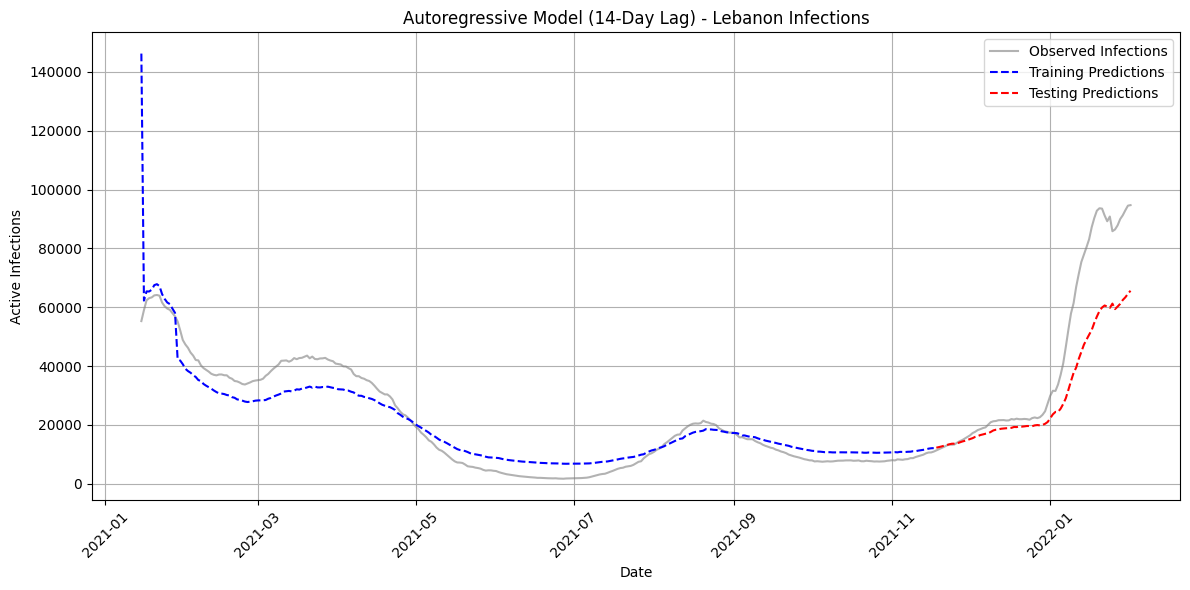

Train RMSE: 7163.72
Test RMSE: 17548.93


In [ ]:
# Add date filtering:
start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2022-02-01')
mask = (lebanon_pivoted['DATE_REPORT'] >= start_date) & (lebanon_pivoted['DATE_REPORT'] <= end_date)
lebanon_pivoted = lebanon_pivoted.loc[mask]


# Estimate recovered (assuming 14-day recovery period)
recovery_lag = 14
recovered = np.zeros_like(cumulative_cases)
recovered[recovery_lag:] = cumulative_cases[:-recovery_lag] - cumulative_deaths[:-recovery_lag]

# Active infections = Cumulative cases - Recovered - Deaths
active_infections = cumulative_cases - recovered - cumulative_deaths

N = 5.718e6  # Population of Lebanon in 2021

# Combine into a clean DataFrame
sird_data = pd.DataFrame({
    'Date': lebanon_pivoted['DATE_REPORT'],
    'Susceptible': N - active_infections - recovered - cumulative_deaths,  # N = population of China
    'Infected': active_infections,
    'Recovered': recovered,
    'Deceased': cumulative_deaths
})


data = sird_data[['Date', 'Infected']].copy()
data.set_index('Date', inplace=True)

# Create 14-day lagged features
for lag in range(1, 15):
    data[f'lag_{lag}'] = data['Infected'].shift(lag)

# Drop rows with NaN (first 14 days lost due to lagging)
data.dropna(inplace=True)

# Define features (X) and target (y)
X = data.drop(columns=['Infected'])  # Lagged features
y = data['Infected']                 # Current infections

# Split based on time (80% train, 20% test)
split_date = data.index[int(len(data)*0.8)]
X_train = X[X.index <= split_date]
y_train = y[y.index <= split_date]
X_test = X[X.index > split_date]
y_test = y[y.index > split_date]

# Initialize and fit model
ar_model = LinearRegression()
ar_model.fit(X_train, y_train)

# Predict on training and testing sets
train_pred = ar_model.predict(X_train)
test_pred = ar_model.predict(X_test)

plt.figure(figsize=(12, 6))

# Plot observed data
plt.plot(data.index, y, label='Observed Infections', color='gray', alpha=0.6)

# Plot training predictions
plt.plot(X_train.index, train_pred, label='Training Predictions', color='blue', linestyle='--')

# Plot testing predictions
plt.plot(X_test.index, test_pred, label='Testing Predictions', color='red', linestyle='--')

# Formatting
plt.title('Autoregressive Model (14-Day Lag) - Lebanon Infections')
plt.xlabel('Date')
plt.ylabel('Active Infections')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")